In [1]:
using CSV
using DataFrames
using Serialization
using Dates

In [2]:
using Distributions
using LinearAlgebra: norm
using ProgressMeter
using BlackBoxOptim

In [3]:
using Gadfly

In [4]:
ENV["COLUMNS"] = 1000;

In [5]:
los_dist_default = (
    icu = Weibull(1.58, 13.32),
    acute = Weibull(1.38, 12.88),
    allbeds = Weibull(1.38, 12.88),
);

In [6]:
rawdata = DataFrame(CSV.File("../data/hhs_data_2021_02_28.csv"))

,hospital,hospital_id,date,admissions_icu,admissions_acute,admissions_allbeds,active_icu,active_acute,active_allbeds
,String,String,Date,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,ABBEVILLE AREA MEDICAL CENTER,421301,2020-07-31,0.471429,1.1,1.57143,1.71429,1.42857,3.14286
2,ABBEVILLE AREA MEDICAL CENTER,421301,2020-08-01,0.446939,1.04286,1.4898,1.59184,1.73469,3.32653
3,ABBEVILLE AREA MEDICAL CENTER,421301,2020-08-02,0.422449,0.985714,1.40816,1.46939,2.04082,3.5102
4,ABBEVILLE AREA MEDICAL CENTER,421301,2020-08-03,0.397959,0.928571,1.32653,1.34694,2.34694,3.69388
5,ABBEVILLE AREA MEDICAL CENTER,421301,2020-08-04,0.373469,0.871429,1.2449,1.22449,2.65306,3.87755
6,ABBEVILLE AREA MEDICAL CENTER,421301,2020-08-05,0.34898,0.814286,1.16327,1.10204,2.95918,4.06122
7,ABBEVILLE AREA MEDICAL CENTER,421301,2020-08-06,0.32449,0.757143,1.08163,0.979592,3.26531,4.2449
8,ABBEVILLE AREA MEDICAL CENTER,421301,2020-08-07,missing,missing,missing,0.857143,missing,missing
9,ABBEVILLE AREA MEDICAL CENTER,421301,2020-08-08,missing,missing,missing,0.734694,missing,missing


In [7]:
valuecols = [:admissions_icu, :admissions_acute, :admissions_allbeds, :active_icu, :active_acute, :active_allbeds];

In [8]:
isbad(x) = isnothing(x) || ismissing(x) || isinf(x) || isnan(x);
isnbad(x) = !isbad(x);

In [9]:
function interpolate_missing(xs::Array{Union{T,Missing},2}) where T <: Real
    output = Array{Float64,2}(undef, size(xs)...)
    for i in 1:size(xs,1)
        output[i,:] = interpolate_missing(xs[i,:])
    end
    return output
end;

function interpolate_missing(xs::Array{Union{T,Missing},1}) where T <: Real
    if all(isbad.(xs))
        return zeros(T, length(xs))
    end
    
    xs = convert.(Union{Float64,Missing}, deepcopy(xs))
    for i in 1:length(xs)
        if isbad(xs[i])
            a = findprev(isnbad, xs, i)
            b = findnext(isnbad, xs, i)
            
            a = isnothing(a) ? b : a
            b = isnothing(b) ? a : b
            
            m = (a==b) ? 0 : ((xs[b]-xs[a]) / (b-a))
            xs[i] = (m * (i-a)) + xs[a]
        end
    end
    return xs
end;

function interpolate_missing(df_::AbstractDataFrame)
    df = DataFrame(deepcopy(df_))
    for col in valuecols
        df[!,col] = interpolate_missing(df[!,col])
    end
    return df
end;

In [10]:
function compute_active_nosent(_initial::Array{<:Real,1}, _discharged::Array{<:Real,2},
        _admitted::Array{<:Real,2}, los_dist::Distribution; use_rounding=false)
    N, T = size(_admitted)
    _L = 1.0 .- cdf.(los_dist, 0:T)
    _active = [(
        _initial[i]
        - sum(_discharged[i,1:t])
        + sum(_L[t-t₁+1] * _admitted[i,t₁] for t₁ in 1:t)
    ) for i in 1:N, t in 1:T]
    if use_rounding
        _active = round.(Int, _active)
    end
    return _active
end;

function compute_active_nosent(_initial::Real, _discharged::Array{<:Real,1},
        _admitted::Array{<:Real,1}, los_dist::Distribution; use_rounding=false)
    T = length(_admitted)
    _L = 1.0 .- cdf.(los_dist, 0:T)
    _active = [(
        _initial
        - sum(_discharged[1:t])
        + sum(_L[t-t₁+1] * _admitted[t₁] for t₁ in 1:t)
    ) for t in 1:T]
    if use_rounding
        _active = round.(Int, _active)
    end
    return _active
end;

In [11]:
function estimate_los(data; optim_time=10.0)
    N, T = data.N, data.T

    function unpack_params(_params)
        alpha, theta = _params
        dist = Gamma(alpha, theta)
        return dist
    end

    function _score_func(params)
        los_dist = unpack_params(params)
        _discharged = [data.initial[i] * pdf(los_dist, t) for i in 1:N, t in 1:T]
        _active = compute_active_nosent(data.initial, _discharged, data.admitted, los_dist, use_rounding=false)
        score = norm(_active - data.active, 2)
        return score
    end

    param_bounds = [(0.0,40.0), (0.0,40.0)]

    r = bboptimize(
        _score_func,
        SearchRange = param_bounds,
        Method = :adaptive_de_rand_1_bin_radiuslimited,
        TraceMode = :silent,
        MaxTime = optim_time,
        RandomizeRngSeed = false,
        RngSeed = 0,
    )

    best_params = best_candidate(r)
    los_dist = unpack_params(best_params)

    return los_dist
end;

In [12]:
function estimate_los_single(data; optim_time=10.0)
    T = data.T

    function unpack_params(_params)
        alpha, theta = _params
        dist = Gamma(alpha, theta)
        return dist
    end

    function _score_func(params)
        los_dist = unpack_params(params)
        _discharged = [data.initial * pdf(los_dist, t) for t in 1:T]
        _active = compute_active_nosent(data.initial, _discharged, data.admitted, los_dist, use_rounding=false)
        score = norm(_active - data.active, 2)
        return score
    end

    param_bounds = [(0.0,40.0), (0.0,40.0)]

    r = bboptimize(
        _score_func,
        SearchRange = param_bounds,
        Method = :adaptive_de_rand_1_bin_radiuslimited,
        TraceMode = :silent,
        MaxTime = optim_time,
        RandomizeRngSeed = false,
        RngSeed = 0,
    )

    best_params = best_candidate(r)
    los_dist = unpack_params(best_params)

    return los_dist
end;

In [13]:
function estimate_discharged_simple_all(data, los_dist)
    discharged = [data.initial[i] * pdf(los_dist, t) for i in 1:data.N, t in 1:data.T]
    return discharged
end;

In [14]:
function estimate_discharged_simple(d, los_dist)
    discharged = [d.initial * pdf(los_dist, t) for t in 1:d.T]
    return discharged
end;

In [15]:
function extract_data(bedtype)
    hospital_ids = sort(unique(rawdata.hospital_id))
    date_range = sort(unique(rawdata.date))
    
    data_dict = Dict((row.hospital_id, row.date) => (
            active = row["active_$(bedtype)"],
            admissions = row["admissions_$(bedtype )"],
        )
        for row in eachrow(rawdata)
    )
    
    admissions = [haskey(data_dict, (h,d)) ? data_dict[(h,d)].admissions : missing for h in hospital_ids, d in date_range]
    active = [haskey(data_dict, (h,d)) ? data_dict[(h,d)].active : missing for h in hospital_ids, d in date_range]
    
    admissions = interpolate_missing(admissions)
    active = interpolate_missing(active)
    
    return (
        N = length(hospital_ids),
        T = length(date_range),
        date_range = date_range,
        start_date = minimum(date_range),
        end_date = maximum(date_range),
        admitted = admissions,
        active = active,
        initial = active[:,1],
    )
end;

In [16]:
function extract_data_total(bedtype)
    hospital_ids = sort(unique(rawdata.hospital_id))
    date_range = sort(unique(rawdata.date))
    
    data_dict = Dict((row.hospital_id, row.date) => (
            active = row["active_$(bedtype)"],
            admissions = row["admissions_$(bedtype )"],
        )
        for row in eachrow(rawdata)
    )
    
    admissions = [haskey(data_dict, (h,d)) ? data_dict[(h,d)].admissions : missing for h in hospital_ids, d in date_range]
    active = [haskey(data_dict, (h,d)) ? data_dict[(h,d)].active : missing for h in hospital_ids, d in date_range]
    
    admissions = interpolate_missing(admissions)
    active = interpolate_missing(active)
    
    admissions_total = sum(admissions, dims=1)[:]
    active_total = sum(active, dims=1)[:]
    
    return (
        N = 1,
        T = length(date_range),
        date_range = date_range,
        start_date = minimum(date_range),
        end_date = maximum(date_range),
        admitted = admissions_total,
        active = active_total,
        initial = active_total[1],
    )
end;

In [17]:
function plot_dist(dist; max_value=50, norm_dist=false, distname="", returnplot=false, showplot=true)

    step = 0.1
    xs = 0 : step : max_value
    
    dist_vals = pdf.(dist, xs)
    dist_vals = norm_dist ? (dist_vals / sum(dist_vals)) : dist_vals
        
    plt = plot(
        layer(
            x = xs,
            y = dist_vals,
            ymax = dist_vals,
            ymin = zeros(length(xs)),
            Geom.ribbon,
            Geom.line,
        ),
        Coord.Cartesian(xmin=0, xmax=max_value, ymax=0.12),
        Guide.xticks(ticks=0:10:max_value),
        Guide.yticks(ticks=0:0.03:0.12),
        Guide.xlabel("LOS"), Guide.ylabel("Frequency"),
        Guide.title("LOS Distribution ($(distname))"),
    )
    
    if showplot
        plt |> SVG(16cm, 10cm)
    end
    
    if returnplot
        return plt
    end
    
    return
end;

In [18]:
bedtypes = [:icu, :acute, :allbeds];

In [19]:
data_total = Dict()
for bedtype in bedtypes
    data_total[bedtype] = extract_data_total(bedtype)
end

In [20]:
los_dist_est = Dict()
for bedtype in bedtypes
    d = data_total[bedtype]
    dist = estimate_los_single(d)
    los_dist_est[bedtype] = dist
end

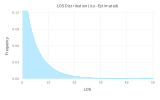

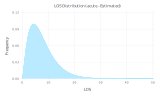

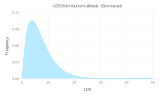

In [21]:
for bedtype in bedtypes
    dist = los_dist_est[bedtype]
    plot_dist(dist, distname="$(bedtype) - Estimated")
end

In [22]:
for bedtype in bedtypes
    dist = los_dist_est[bedtype]
    println(bedtype)
    println("Mean: $(mean(dist))")
    println("Std: $(std(dist))")
    println()
end

icu
Mean: 5.008395642568999
Std: 5.607188136848903

acute
Mean: 7.64991271003586
Std: 5.01765353944511

allbeds
Mean: 7.018786156833292
Std: 4.863778685918226



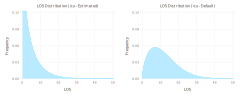

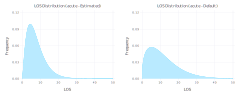

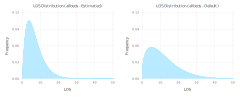

In [23]:
for bedtype in bedtypes
    dist_est = los_dist_est[bedtype]
    dist_default = los_dist_default[bedtype]
    p1 = plot_dist(dist_est, distname="$(bedtype) - Estimated", showplot=false, returnplot=true)
    p2 = plot_dist(dist_default, distname="$(bedtype) - Default", showplot=false, returnplot=true)
    hstack(p1, p2) |> SVG(24cm, 10cm)
end

In [24]:
function score_func(d, los_dist)
    _discharged = [d.initial * pdf(los_dist, t) for t in 1:d.T]
    _active = compute_active_nosent(d.initial, _discharged, d.admitted, los_dist, use_rounding=false)
    score = norm(_active - d.active, 2)
    return score
end;

In [25]:
for bedtype in bedtypes
    d = data_total[bedtype]
    dist_est = los_dist_est[bedtype]
    dist_default = los_dist_default[bedtype]
    println(bedtype)
    println("Estimate score:\t$(score_func(d, dist_est))")
    println("Default score:\t$(score_func(d, dist_default))")
    println()
end

icu
Estimate score:	10942.344380208979
Default score:	257507.3091925787

acute
Estimate score:	48066.38527518131
Default score:	391501.69874029513

allbeds
Estimate score:	42352.61734909857
Default score:	640519.7293957153



In [26]:
function plot_estimates_total(data, los_dist)
    _discharged = estimate_discharged_simple(data, los_dist)
    active_computed = compute_active_nosent(
        data.initial,
        _discharged,
        data.admitted,
        los_dist,
    )
    
    colors = Scale.default_discrete_colors(3)[[1,3]]
    
    plt_active_computed = plot(
        layer(x=data.date_range, y=data.active, Geom.point, Geom.line, style(default_color=colors[1])),
        layer(x=data.date_range, y=active_computed, Geom.point, Geom.line, style(default_color=colors[2])),
        Guide.xlabel("Date"), Guide.ylabel("Active COVID Patients"), Guide.title("Total Active COVID Patients - Raw vs Computed"),
        Guide.manual_color_key("", ["Data", "Computed"], colors[[1,2]], shape=[Shape.square], size=[1.6mm]),
        Scale.x_continuous(labels=x -> Dates.format(x, dateformat"yy-mm-dd")),
        Scale.y_continuous(format=:plain),
        Coord.cartesian(ymin=0),
    )

    plt_admitted_computed = plot(
        layer(x=data.date_range, y=data.admitted, Geom.point, Geom.line, style(default_color=colors[1])),
        Guide.xlabel("Date"), Guide.ylabel("Admitted Patients"),
        Guide.title("Total Admitted Patients - Estimated"),
        Scale.x_continuous(labels=x -> Dates.format(x, dateformat"yy-mm-dd")),
        Scale.y_continuous(format=:plain),
    )
    
    plt = hstack(plt_active_computed, plt_admitted_computed)
    plt |> SVG(40cm, 10cm)
        
    return
end;

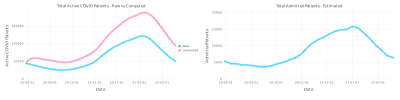

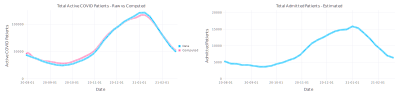

In [27]:
plot_estimates_total(data_total[:allbeds], los_dist_default[:allbeds])
plot_estimates_total(data_total[:allbeds], los_dist_est[:allbeds])

In [28]:
los_dist_est

Dict{Any,Any} with 3 entries:
  :acute   => Gamma{Float64}(α=2.3244, θ=3.29113)
  :allbeds => Gamma{Float64}(α=2.08246, θ=3.37043)
  :icu     => Gamma{Float64}(α=0.797824, θ=6.27757)

In [29]:
serialize("../data/hhs_los_est.jlser", los_dist_est);